<a href="https://colab.research.google.com/github/kicysh/final_task_of_world_model_lecture_2021/blob/main/docs/compare_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# command line
以下のpipセクション終了後に必ず**ランタイムの再起動**を行うこと

In [1]:
!pip install scanpy scikit-misc

# install ldvae
!git clone https://github.com/kicysh/final_task_of_world_model_lecture_2021/
!pip install final_task_of_world_model_lecture_2021/package/. --use-feature=in-tree-build

     |████████████████████████████████| 2.0 MB 9.0 MB/s 
     |████████████████████████████████| 8.8 MB 25.7 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
     |████████████████████████████████| 96 kB 5.2 MB/s 
     |████████████████████████████████| 11.2 MB 41.4 MB/s 
     |████████████████████████████████| 900 kB 57.0 MB/s 
     |████████████████████████████████| 1.1 MB 41.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=e9577d78b2e2dc53c1a1978dcbb08a662da444620effe47643d435992696be70
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=744645375d4c448e327a776df157ef2cea6d9b2854f8bac15ebefa2e3dd79280
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
  Created 

Cloning into 'final_task_of_world_model_lecture_2021'...
remote: Enumerating objects: 235, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 235 (delta 46), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (235/235), 26.04 MiB | 8.47 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Processing ./final_task_of_world_model_lecture_2021/package
  Created wheel for LDVAE: filename=LDVAE-0.1.0-py3-none-any.whl size=3274 sha256=3e6dce4754524349c74ead33c9520292944cb4d7fdb67c074d7bd265e76a2278
  Stored in directory: /tmp/pip-ephem-wheel-cache-5o1xv2pp/wheels/e2/2f/44/da18d64c7ac8950bd4f266d145db33398678d80aff1a4f488f
Successfully built LDVAE


In [2]:
!mkdir data figures intermediate

import gdown
gdown.download('https://drive.google.com/uc?id=1PedYqkkEClou4iQQbfrAkmHVydiJrQVb', '/content/data/train_data.h5ad', quiet=False,)


Downloading...
From: https://drive.google.com/uc?id=1PedYqkkEClou4iQQbfrAkmHVydiJrQVb
To: /content/data/train_data.h5ad
100%|██████████| 23.5M/23.5M [00:00<00:00, 141MB/s] 


'/content/data/train_data.h5ad'

In [3]:
!pip list

Package                       Version
----------------------------- ---------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
anndata                       0.8.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.4
branca                        0.4.2
bs4   

# setting


In [11]:
import ldvae

import numpy as np
import pandas as pd

import random

import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F
#from torch import logsumexp
#from torch.distributions import Normal, kl_divergence
import sklearn.model_selection

import matplotlib.pyplot as plt

import scanpy as sc

In [2]:
# global
USE_CUDA = True

# model params
SETTING_HIDDEN_DIMS = (128,)
SETTING_LATENT_DIM = 20
SETTING_USE_NORM = True

SETTING_BATCH_SIZE = 1024

SETTING_N_TOP_GENES = 1000

SETTING_TRAIN_RATE = 0.8
SETTING_VAL_RATE = 0.2

DATA_PATH = '/content/data/train_data.h5ad'
W_CSV_PATH = '/content/intermediate/w.csv'
Z_CSV_PATH = '/content/intermediate/z.csv'

RANDOM_SEED = 42

In [3]:
# 再現性のため
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

GENERATOR = torch.Generator()
GENERATOR.manual_seed(RANDOM_SEED)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# data

## read data

In [4]:
adata = sc.read_h5ad(DATA_PATH)
adata

/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/anndata/compat/__init__.py:235: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'

## 前処理

In [5]:
sc.pp.highly_variable_genes(adata,n_top_genes=SETTING_N_TOP_GENES ,flavor='seurat_v3')
print(adata)


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,


AnnData object with n_obs × n_vars = 16893 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors', 'hvg'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'distances', 'connectivities'


In [6]:
gene_index = adata.var[adata.var['highly_variable']].index
adata_df = adata.to_df()[gene_index]


## create dataset

In [7]:
class GenesDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 adata: np.array, 
                 transform=None, 
                 target_transform=None):
        self.data = adata
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data)

    def __getattr__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data = self.data[idx]
        if self.transform:
            data = self.transform(data)
        return data

## create dataloader

In [8]:
# dataloder
dataset = GenesDataset(adata_df.values)

n_samples = len(dataset) 
train_size = int(n_samples* SETTING_TRAIN_RATE)
val_size = int(n_samples * SETTING_VAL_RATE)
test_size = n_samples - train_size - val_size 

dataset_train ,dataset_valid, dataset_test = \
        torch.utils.data.random_split(dataset,
                                      [train_size, val_size,test_size],
                                      generator=GENERATOR)

dataloader_all = torch.utils.data.DataLoader(
    dataset,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=False,
)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    num_workers=4, 
    pin_memory=True, 
    worker_init_fn=seed_worker, 
    generator=GENERATOR
)

dataloader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=SETTING_BATCH_SIZE,
    shuffle=True,
    #generator=GENERATOR.manual_seed(RANDOM_SEED)
)


# model

## define model

In [9]:
model = ldvae.LDVAE(genes_cnt = len(adata_df.columns),
                    hidden_dims=SETTING_HIDDEN_DIMS,
                    latent_dim = SETTING_LATENT_DIM)
model.set_local_l_mean_and_var(adata_df.values)
model

LDVAE(
  (encoder_z): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_z_mean): Linear(in_features=128, out_features=20, bias=True)
  (encoder_z_var): Linear(in_features=128, out_features=20, bias=True)
  (encoder_l): Sequential(
    (0): Linear(in_features=1000, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
  )
  (encoder_l_mean): Linear(in_features=128, out_features=1, bias=True)
  (encoder_l_var): Linear(in_features=128, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=1000, bias=False)
    (1): BatchNorm1d(1000, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
)

## train

In [12]:
n_epochs  = 100
optimizer = optim.Adam(model.parameters(), lr=7e-3)

device = 'cuda'  if USE_CUDA else 'cpu'
model.to(device)


kf = sklearn.model_selection.KFold(n_splits=3,
                                   shuffle=True,
                                   random_state= RANDOM_SEED)


for _fold, (index_train, index_valid) in enumerate(kf.split(adata_df.values)):

    # dataset and dataloader===========================================
    dataset_train = torch.utils.data.dataset.Subset(dataset, index_train)
    dataloader_train = torch.utils.data.DataLoader(
                                            dataset_train,
                                            batch_size=SETTING_BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=4,
                                            pin_memory=True, 
                                            worker_init_fn=seed_worker, 
                                            generator=GENERATOR
                                               )
    dataset_valid   = torch.utils.data.dataset.Subset(dataset, index_valid)
    dataloader_valid = torch.utils.data.DataLoader(
                                            dataset_train,
                                            batch_size=SETTING_BATCH_SIZE,
                                            shuffle=True,
                                            num_workers=4,
                                            pin_memory=True, 
                                            worker_init_fn=seed_worker, 
                                            generator=GENERATOR
                                               )
    # model====================================
    model = ldvae.LDVAE(genes_cnt = len(adata_df.columns),
                        hidden_dims=SETTING_HIDDEN_DIMS,
                        latent_dim = SETTING_LATENT_DIM)
    model.set_local_l_mean_and_var(adata_df.values)
    for epoch in range(n_epochs):
        losses = []

        model.train()
        for x in dataloader_train:
            x = x.to(device)

            #model.zero_grad()
            optimizer.zero_grad()
            # forawrd and loss
            reconst, kl_l ,kl_z = model.loss(x)
            loss = torch.mean(-reconst+kl_l +kl_z)

            nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            loss.backward()
            optimizer.step()

            losses.append(loss.cpu().detach().numpy())

        losses_val1 = []
        losses_val2 = []
        losses_val3 = []

        model.eval()
        for x in dataloader_valid:

            x = x.to(device)
            reconst, kl_l ,kl_z = model.loss(x)

            losses_val1.append(torch.mean(-reconst).cpu().detach().numpy())
            losses_val2.append(torch.mean(kl_l).cpu().detach().numpy())
            losses_val3.append(torch.mean(kl_z).cpu().detach().numpy())

        print('EPOCH: %d    Train Loss: %lf    Valid rec: %lf    Valid kl_l: %lf    Valid kl_z: %lf' %
                (epoch+1, np.average(losses),np.average(losses_val1),np.average(losses_val2),np.average(losses_val3)))


EPOCH: 1    Train Loss: 429.563660    Valid rec: 1005.767151    Valid kl_l: 66.068428    Valid kl_z: 18.786226
EPOCH: 2    Train Loss: 257.995758    Valid rec: 945.158264    Valid kl_l: 74.068237    Valid kl_z: 15.571597
EPOCH: 3    Train Loss: 235.015823    Valid rec: 968.914673    Valid kl_l: 73.561249    Valid kl_z: 15.422507
EPOCH: 4    Train Loss: 222.190582    Valid rec: 932.063721    Valid kl_l: 55.249866    Valid kl_z: 13.239066
EPOCH: 5    Train Loss: 212.826019    Valid rec: 858.383789    Valid kl_l: 43.864185    Valid kl_z: 11.203528
EPOCH: 6    Train Loss: 205.349304    Valid rec: 817.174438    Valid kl_l: 41.485287    Valid kl_z: 9.983496
EPOCH: 7    Train Loss: 200.145203    Valid rec: 596.766846    Valid kl_l: 29.712877    Valid kl_z: 9.130057
EPOCH: 8    Train Loss: 194.966202    Valid rec: 498.008179    Valid kl_l: 24.507978    Valid kl_z: 8.705579
EPOCH: 9    Train Loss: 190.415909    Valid rec: 455.944427    Valid kl_l: 20.996408    Valid kl_z: 8.174660
EPOCH: 10    

Exception ignored in: <function _releaseLock at 0x7f00d3c648c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: ignored

# output intermediate files

## output weight

In [13]:
# w
import pandas as pd

_w = model.decoder[0].weight
bn = model.decoder[1]
sigma = torch.sqrt(bn.running_var + bn.eps)
gamma = bn.weight
b = gamma / sigma
bI = torch.diag(b)
loadings = torch.matmul(bI, _w)
loadings = loadings.detach().cpu().numpy()

W = pd.DataFrame(loadings, index=gene_index)
W.to_csv(W_CSV_PATH)


## output the latent variables (z)

In [14]:
# z
latent_array  = None
model.eval()
for x in dataloader_all:
    x = x.to(device)
    _z,_,_ = model(x)
    z_mean,_,_ = _z
    z_mean = z_mean.cpu().detach().numpy()
    if latent_array is None:
        latent_array = z_mean
    else:
        latent_array = np.concatenate([latent_array, z_mean])
pd.DataFrame(latent_array,index=adata_df.index).to_csv(Z_CSV_PATH)

# output figures

In [15]:
%pylab inline
%config InlineBackend.figure_format ='retina'


import matplotlib.colors as mcolors

#import plotnine as p

from matplotlib.patches import Ellipse
from scipy import stats
import matplotlib.cm as cm

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['gamma', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [16]:
w_df = pd.read_csv(W_CSV_PATH, index_col=0)
z_df = pd.read_csv(Z_CSV_PATH, index_col=0)

w_df = w_df.add_prefix('w')
z_df = z_df.add_prefix('z')

print('w_df====================')
print(w_df.head())
print('z_df====================')
print(z_df.head())

w_df====================
                w0        w1        w2        w3        w4        w5  \
index                                                                  
HES4      0.410925 -0.179634 -0.626542 -0.674862  0.418932  0.022071   
ISG15     0.094064 -0.003224 -1.025101 -0.078675  2.335755  0.008711   
TNFRSF18  0.068087  0.579884  0.808832  0.388170 -0.123809 -0.037889   
TNFRSF4   0.053977  0.310655  0.397176  0.078914 -0.549446  0.035954   
PRKCZ     0.036659 -0.073356  0.395496  0.133004 -0.262194  0.013056   

                w6        w7        w8        w9       w10       w11  \
index                                                                  
HES4     -0.026551 -0.028121 -0.278233 -0.037865  0.619826 -0.103790   
ISG15    -0.038683  0.089645  0.124763  0.104090  0.049591  0.028463   
TNFRSF18 -0.148506 -0.023489 -0.586275 -0.046634  0.581739  0.186626   
TNFRSF4  -0.579436  0.005677 -0.387290  0.285305  0.051637  0.161905   
PRKCZ     0.134320  0.263794  0.078217

In [17]:
import umap
#from sklearn.manifold import TSNE

#X_reduced = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(z_df.values)
X_reduced = umap.UMAP().fit_transform(z_df.values)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [18]:
def create_fig(title: str = 'title',
               save: bool = True,
               save_name: str = 'figures/fig.pdf',
               close: bool= False
               ):
    """
    create a scatter figure form 2 dims.
    
    params
    ------
    title: str, default 'title'
        figure title
    save: bool, default True
    save_name: str, default 'figures/fig.pdf'
        If you set save to False, ignore save_name.
    close: bool, default False
        If set close to True, run plt.colse() after plt.save().
    """
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(1,1,1)
    #ax.set_title('the 10 latent variables view with umap')
    ax.set_title(title)
    for cell_type,cell_type_color in zip(adata.obs.cell_type.values.categories,adata.uns['cell_type_colors']):
        x = X_reduced[(adata.obs.cell_type==cell_type).values,0]
        y = X_reduced[(adata.obs.cell_type==cell_type).values,1]
        ax.scatter(x, y, c=cell_type_color,s=0.5,label=cell_type,alpha=0.5)

    #ax.legend()
    ax.legend(title = "Cell Type", 
            title_fontsize = "large",
            labelspacing = 1,
            handletextpad= 0.5,
            frameon=False, # 枠を消す
            markerscale = 10, # マーカーの大きさ
            loc='upper left', # 位置の設定
            bbox_to_anchor=(1, 1) # 位置の設定
            )
    if save:
        plt.savefig(save_name, bbox_inches='tight', dpi=800)
    if close:
        plt.close()


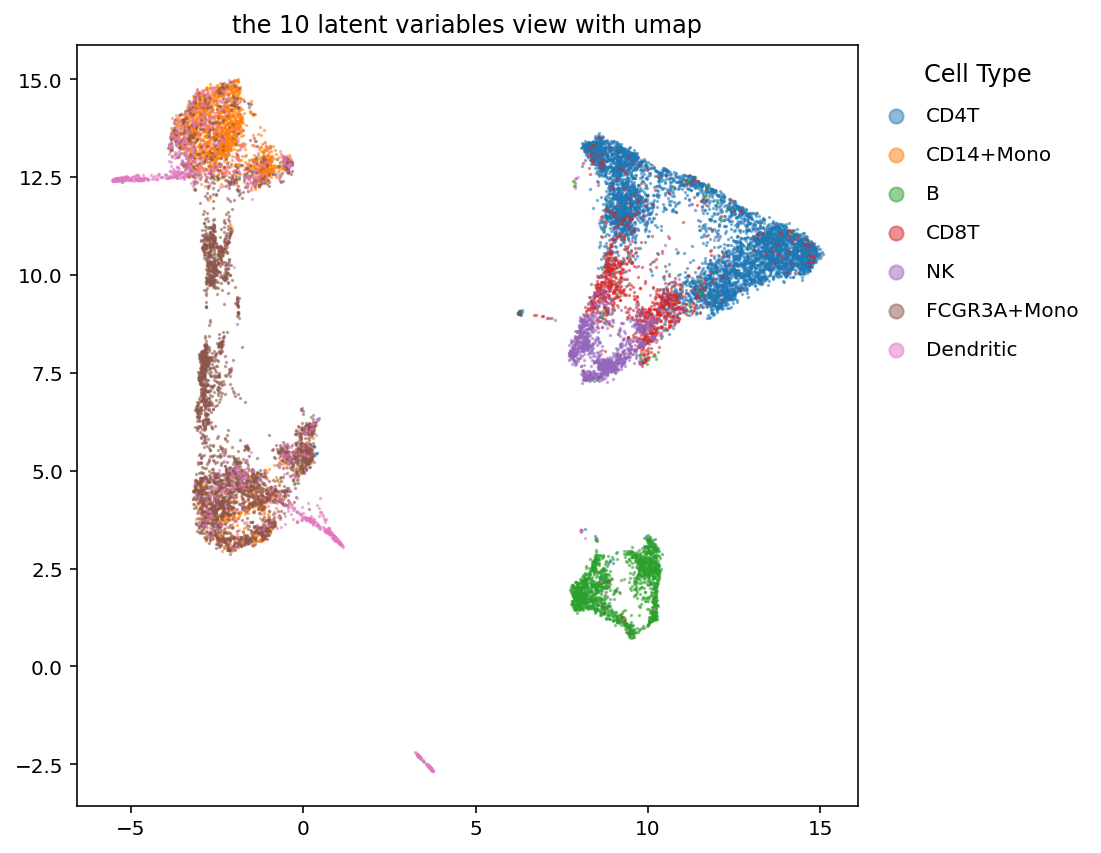

In [19]:
create_fig(title='the 10 latent variables view with umap',)

# EXTRA

In [20]:
def Z_covariance(Z):
    """
    return matrix and explained variance

    params
    -------
    Z: np.array

    return
    ------
    ZTZ: np.array
    variance_explained: np.array
    """
    #Zcentered = Z - Z.mean(0)
    Zscaled = Z / Z.std(0)
    ZTZ = np.cov(Zscaled.T)
    
    eigen_values, _ = np.linalg.eig(ZTZ)
    singular_values = np.sqrt(eigen_values)
    variance_explained = singular_values / singular_values.sum()

    return ZTZ, variance_explained

In [21]:
# descending order by explained variance
_, variance_explained = Z_covariance(z_df)
idx = np.argsort(variance_explained)[::-1]

Z_df_ordered = pd.DataFrame(z_df.values[:, idx]).add_prefix('z')
Z_df_ordered.index = z_df.index
metadata = adata.obs.loc[Z_df_ordered.index].join(Z_df_ordered)

W_df_ordered = pd.DataFrame(w_df.values[:, idx]).add_prefix('w')
W_df_ordered.index = w_df.index
W_df_ordered = adata.var.loc[W_df_ordered.index].join(W_df_ordered)
vardata = W_df_ordered

In [22]:

print('相関係数 ===================================')
for ctype in np.unique(metadata['cell_type']):
    z_corrs = Z_df_ordered.corrwith((metadata['cell_type'] == ctype))
    top_factors = z_corrs.map(np.abs).sort_values(ascending=False).head(3)
    print([f'{z.rjust(3)}: {z_corrs[z]:+.2f}' for z in top_factors.index], ctype)

相関係数 ===================================
[' z3: +0.57', ' z9: -0.56', 'z13: +0.27'] B
['z12: +0.54', ' z6: -0.40', 'z16: -0.32'] CD14+Mono
['z12: -0.68', ' z9: +0.59', ' z6: +0.44'] CD4T
['z13: -0.35', 'z10: +0.22', ' z6: +0.20'] CD8T
['z18: -0.46', 'z12: +0.22', ' z9: -0.18'] Dendritic
[' z2: -0.52', ' z3: -0.49', ' z6: -0.39'] FCGR3A+Mono
['z10: +0.41', 'z13: -0.35', 'z14: +0.32'] NK


In [ ]:
# ダウンロードしたいフォルダを zip 圧縮する
!zip -r /content/download.zip /content/figures

# 圧縮した zip ファイルをダウンロードする
from google.colab import files
files.download("/content/download.zip")